# LBM Step 1: Pre-Processing

## Steps:

**1a.** Set up filepaths.

**1b.** Extract ScanImage metadata.

**1c.** Use metadata to de-interleave frames into planar timeseries.

**1d.** Correct Bi-Directional Offset for each ROI.


In [2]:
## Imports
%load_ext autoreload
%autoreload 2

import time
import sys
from pathlib import Path
import numpy as np
import napari
import pandas as pd
import tifffile

sys.path.append('../../util/')  # TODO: Take this out when we upload to pypi
sys.path.append('../..')  # TODO: Take this out when we upload to pypi
import matplotlib.pyplot as plt
import scanreader as sr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up filepaths

For pre-processing, you generally need to hold 2 filepaths:

- input data: path to raw scanimage .tiff files
- output data: path to save the pre-processed datasets

*Note:* To avoid issues with forword vs backslash, Windows filepaths vs Linux filepaths, we recommend using the pythong builtin module [pathlib](https://docs.python.org/3/library/pathlib.html). Examples of its use can be seen throughout these examples, namely via [`pathlib.Path`](https://docs.python.org/3/library/pathlib.html#pure-paths).

In [3]:
parent_dir = Path().home() / 'caiman_data' / 'animal_01' / 'session_01'
directory_contents = [str(x) for x in parent_dir.glob("*")]
raw_tiff_files = [str(x) for x in parent_dir.glob("*.tif*")]
raw_tiff_files

['/home/mbo/caiman_data/animal_01/session_01/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif']

# scanreader 

[scanreader](https://millerbrainobservatory.github.io/LBM-CaImAn-Python/scanreader.html) is a `.tiff` reader (wrapped around [tifffile](https://pypi.org/project/tifffile/)) that extracts ScanImage specific metadata used to horizontally concatenate each ROI.

This reader loads data **lazily**, that is, only when data needs to be loaded into memory and thus allows us to preview small [`chunks`](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes#what-are-dask-array-chunks) our image before performing computations on the entire dataset.

In [4]:
reader = sr.read_scan(raw_tiff_files)

DEBUG:scanreader.scans:Initializing scan with files: ['/home/mbo/caiman_data/animal_01/session_01/MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min_M1_00001_00001.tif']


the `scanreader.data` property will show you the size and chunkshape of the current state of the scanreader:

In [5]:
reader.data

dask.array<empty_like, shape=(1730, 600, 576), dtype=float64, chunksize=(48, 600, 576), chunktype=numpy.ndarray>

## View mean images

In [2]:
import napari

viewer = napari.Viewer()
# dock_widget, plugin_widget = viewer.window.add_plugin_dock_widget("napari-lbm", "LBMWidget")

In [11]:
import vispy
print(vispy.sys_info())

Platform: Linux-5.15.150.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Python:   3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
NumPy:    1.26.4
Backend:  PyQt5
pyqt4:    None
pyqt5:    ('PyQt5', '5.15.10', '5.15.2')
pyqt6:    None
pyside:   None
pyside2:  None
pyside6:  None
pyglet:   None
glfw:     None
sdl2:     None
wx:       None
egl:      EGL 1.5 Mesa Project: OpenGL OpenGL_ES
osmesa:   None
tkinter:  None
jupyter_rfb: None
_test:    None

GL version:  '4.2 (Compatibility Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2'
MAX_TEXTURE_SIZE: 16384
Extensions: 'GL_ARB_multisample GL_EXT_abgr GL_EXT_bgra GL_EXT_blend_color GL_EXT_blend_minmax GL_EXT_blend_subtract GL_EXT_copy_texture GL_EXT_subtexture GL_EXT_texture_object GL_EXT_vertex_array GL_EXT_compiled_vertex_array GL_EXT_texture GL_EXT_texture3D GL_IBM_rasterpos_clip GL_ARB_point_parameters GL_EXT_draw_range_elements GL_EXT_packed_pixels GL_EXT_point_parameters GL_EXT_rescale_normal GL_EXT_separate_specu

In [13]:
viewer.close()

## Save the result

In [47]:
sframes = (2, 802)
nframes = sframes[-1] - sframes[0]

savedir = raw_dir / 'final'
savedir.mkdir(exist_ok=True)
for idx, num in enumerate(range(1, reader.num_channels + 1)):
    filename = savedir / f'extracted_plane_{num}.tif'
    if idx in [0, 1]:
        plane = clear_zeros(reader[2:802, idx, :,:])
        tifffile.imwrite(filename, plane, ome=True, bigtiff=True, metadata={'fps': reader.fps, 'photometric': 'minisblack'})

### To ensure the data was saved properly, load and display a single frame

In [48]:
start = time.time()
test_data = tifffile.imread(savedir / 'extracted_plane_1.tif')
print(time.time() - start)

0.14771318435668945


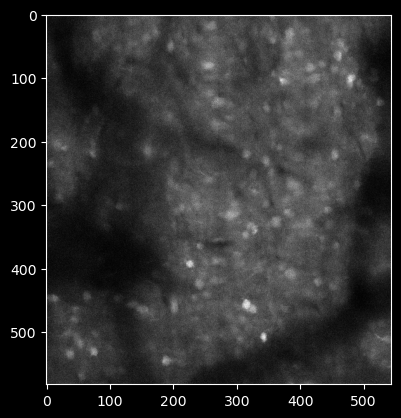

In [50]:
plt.imshow(test_data[0, ...], cmap='gray')
plt.show()

## Data Storage Options: Tiff, Zarr, HDF5

[Zarr documentation](https://zarr.readthedocs.io/en/stable/tutorial.html)

Deciding how to save data on a host operating system is far from straight foreward.
Read/write operations will vary widely between data saved in a **single file**
structure vs smaller chunks, e.g. one image per file, one image per epoch, etc. 
 
The former strategy is clean/consice and easy to handle but is *not* feasable with large (>10GB) datasets. 

The latter strategy of spreading files acrossed nested groups of directories, each with their own metadata/attributes has been widely adopted as the more sensible approach. HDF5 has 
been the frontrunner in scientific data I/O but suffers from widely inconsistent within academia.  

- Zarr, similar to H5, is a heirarchical data storage specification.
- Zarr nicely hides the complexities inherent in linking filesystem heirarchy with efficient data I/O.

### Leverage zarr directory storage to compare pixel trimming

- `zarr.open` is a convenience method that handles chunking and compression for persistant storage.
- We want to keep this data as `16 bit` integers because no calculations should be done yet.

In general, we want this value to be `~1Mb` to optimize write speed. 

```python
name = '/path/to/folder'
chunksize=[300,300,1,1]
z1 = zarr.open(f'{name}', mode='w', shape=(data.shape),chunks=chunksize, dtype='int16')
```